Neural Network for CAP Classification <br>
Author: Apurva R Umredkar <br> <br>
Description: <br>
<ul>
<li>Balanced dataset with 9306 samples (A: 4653/B: 4653).</li>
<li>Hold-out validation training (70-15-15)
<li>Accuracy: 74.64%</li>





In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12049903534372633085, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13156178160974388110
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
# Libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.utils import shuffle
dataset = loadmat(
    "/content/drive/MyDrive/CAP Research Data/eeg _signals_1d_balanced_9306.mat")['val']
#dataset= np.load("/content/drive/MyDrive/CAP Research Data/eeg_data_21984_balanced.npy")
N = dataset.shape[0]
mmscaler = MinMaxScaler()

signals = dataset[:, :1024]
signals_dft = np.fft.fft(signals)
dft_abs = np.abs(signals_dft)
dft_ang = np.angle(signals_dft)

inputs = mmscaler.fit_transform(dft_abs[:, 1:513]).reshape((N, 512, 1))
targets = dataset[:, 1024]

test_size = 0.15

X, Y = shuffle(inputs, targets, random_state=None)
Y = keras.utils.to_categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 512, 1)       0           input_1[0][0]                    
______________________________________________________________________________________________

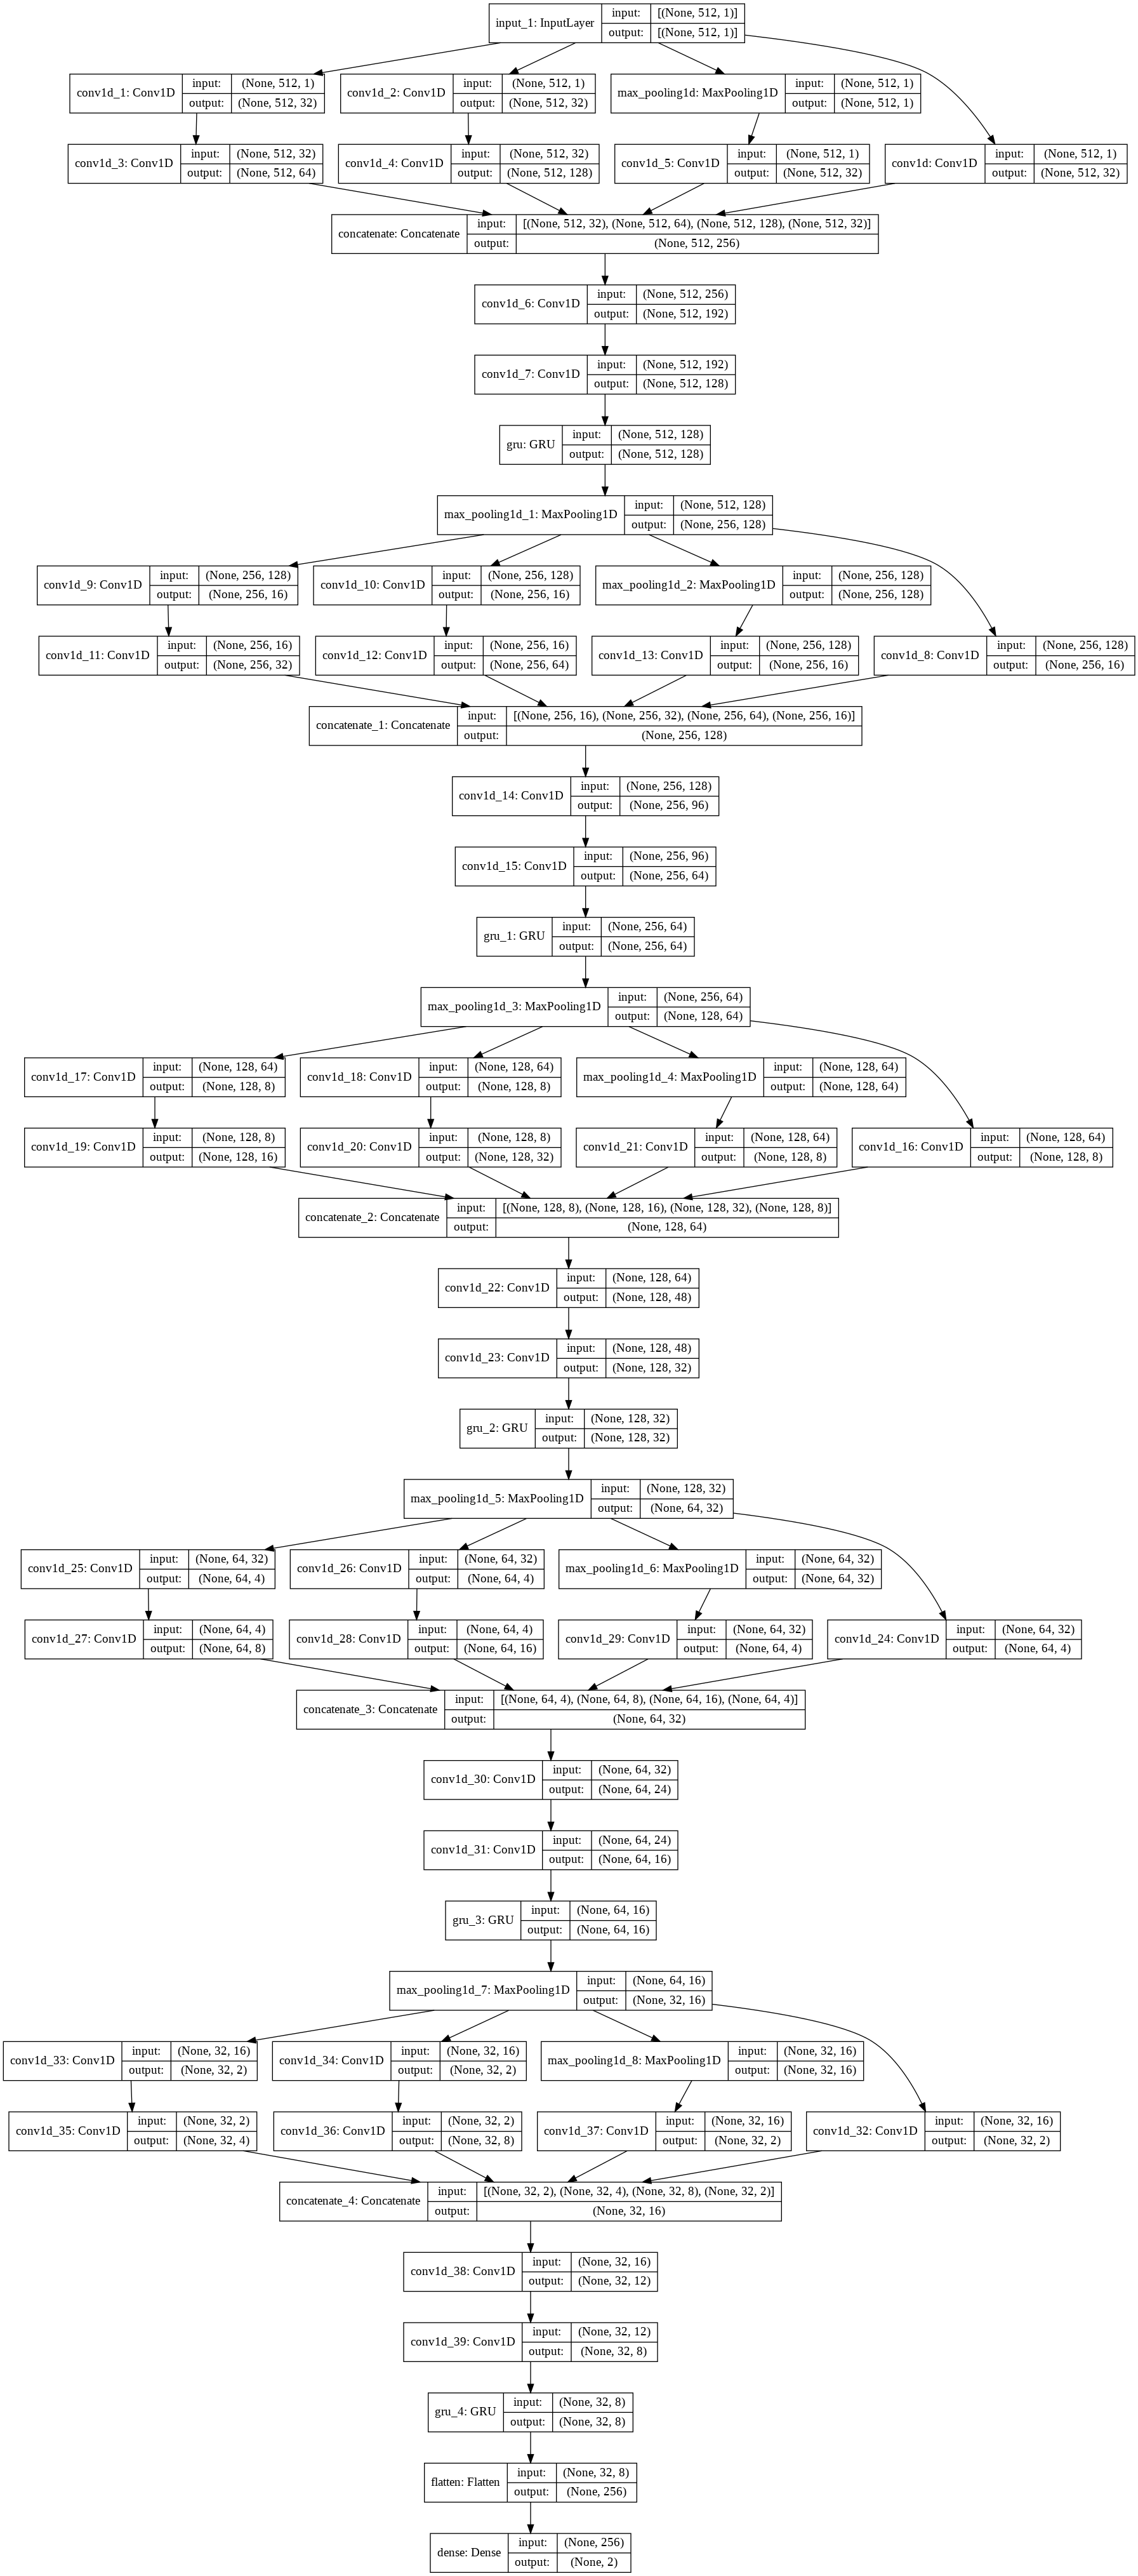

In [ ]:
# Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
    conv1 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    conv2 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    conv3 = Conv1D(f1, 1, activation='relu', padding='same')(layer)
    maxp = MaxPool1D(pool_size=3, strides=1, padding='same')(layer)

    conv2 = Conv1D(f2, 3, activation='relu', padding='same')(conv2)
    conv3 = Conv1D(f3, 5, activation='relu', padding='same')(conv3)
    conv4 = Conv1D(f4, 1, activation='relu', padding='same')(maxp)

    return Concatenate()([conv1, conv2, conv3, conv4])


input_signal = Input(shape=(512, 1))

incept = inception_module(input_signal, 32, 64, 128, 32)
conv = Conv1D(192, 5, activation='relu', padding='same')(incept)
conv = Conv1D(128, 3, activation='relu', padding='same')(conv)
gru = GRU(128, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 16, 32, 64, 16)
conv = Conv1D(96, 5, activation='relu', padding='same')(incept)
conv = Conv1D(64, 3, activation='relu', padding='same')(conv)
gru = GRU(64, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 8, 16, 32, 8)
conv = Conv1D(48, 5, activation='relu', padding='same')(incept)
conv = Conv1D(32, 3, activation='relu', padding='same')(conv)
gru = GRU(32, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 4, 8, 16, 4)
conv = Conv1D(24, 5, activation='relu', padding='same')(incept)
conv = Conv1D(16, 3, activation='relu', padding='same')(conv)
gru = GRU(16, return_sequences=True)(conv)

maxp = MaxPool1D()(gru)

incept = inception_module(maxp, 2, 4, 8, 2)
conv = Conv1D(12, 5, activation='relu', padding='same')(incept)
conv = Conv1D(8, 3, activation='relu', padding='same')(conv)
gru = GRU(8, return_sequences=True)(conv)

flat = Flatten()(gru)
output = Dense(2, activation='softmax')(flat)


if 'model' in globals() or 'model' in locals():
    del model

model = keras.Model(inputs=input_signal, outputs=output)
model.summary()
init_weights = model.get_weights()
plot_model(model, show_shapes=True)


Epoch 1/2500
26/26 [==============================] - 22s 390ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 2/2500
26/26 [==============================] - 6s 227ms/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 3/2500
26/26 [==============================] - 6s 228ms/step - loss: 0.6929 - accuracy: 0.5040 - val_loss: 0.6927 - val_accuracy: 0.5056
Epoch 4/2500
26/26 [==============================] - 6s 228ms/step - loss: 0.6922 - accuracy: 0.5071 - val_loss: 0.6914 - val_accuracy: 0.5119
Epoch 5/2500
26/26 [==============================] - 6s 229ms/step - loss: 0.6899 - accuracy: 0.5529 - val_loss: 0.6875 - val_accuracy: 0.5765
Epoch 6/2500
26/26 [==============================] - 6s 228ms/step - loss: 0.6858 - accuracy: 0.5755 - val_loss: 0.6834 - val_accuracy: 0.5716
Epoch 7/2500
26/26 [==============================] - 6s 229ms/step - loss: 0.6804 - accuracy: 0.5735 - val_loss: 0.6759 - val_accuracy

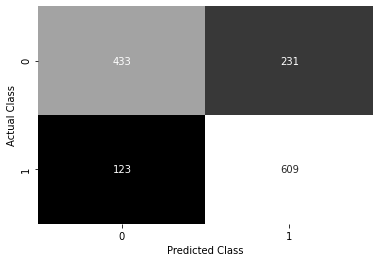

Accuracy Metrics:                 0
count  119.000000
mean     0.701765
std      0.054469
min      0.504009
25%      0.696423
50%      0.724792
75%      0.731036
max      0.740210

Loss Metrics:                 0
count  119.000000
mean     0.565915
std      0.046160
min      0.525258
25%      0.536266
50%      0.545994
75%      0.579079
max      0.693146

Val. Accuracy Metrics:                 0
count  119.000000
mean     0.687453
std      0.048039
min      0.505618
25%      0.688905
50%      0.706461
75%      0.712781
max      0.720506

Val. Loss Metrics:                 0
count  119.000000
mean     0.582785
std      0.037550
min      0.555241
25%      0.560789
50%      0.564540
75%      0.591420
max      0.693122


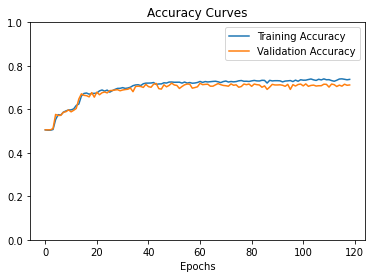

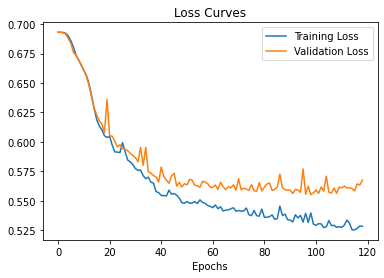

In [ ]:
# Hyperparameters
import pandas as pd
epochs = 2500
batch_size = 256
validation_split = 0.18
lr = 1e-4
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.set_weights(init_weights)

start = time.time()
history = model.fit(X_train, Y_train, validation_split=validation_split,
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stop])
end = time.time()
res = model.evaluate(X_test, Y_test)
# Prediction
Ypred = model.predict(X_test)
Ypred = np.round(Ypred)
print(f'Training time: {end-start:.3f}s\n')
print(classification_report(Y_test, Ypred))

# Confusion Matrix
confmat = confusion_matrix(Y_test.argmax(axis=1), Ypred.argmax(axis=1))

confmat_heatmap = sns.heatmap(
    confmat, annot=True, fmt='', cmap='gray', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

# Stats of Metrics
acc = pd.DataFrame(history.history['accuracy'])
loss = pd.DataFrame(history.history['loss'])
valacc = pd.DataFrame(history.history['val_accuracy'])
valloss = pd.DataFrame(history.history['val_loss'])
print(f'Accuracy Metrics: {acc.describe()}\n')
print(f'Loss Metrics: {loss.describe()}\n')
print(f'Val. Accuracy Metrics: {valacc.describe()}\n')
print(f'Val. Loss Metrics: {valloss.describe()}')

# Plots
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.title(label='Accuracy Curves')
plt.ylim(0, 1)
plt.show()
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.title(label='Loss Curves')
plt.show()


In [ ]:
metrics = pd.DataFrame({'accuracy': history.history['accuracy'], 'val_acc': history.history['accuracy'],
                        'loss': history.history['loss'], 'val_loss': history.history['val_loss']})


In [ ]:
metrics.to_csv(
    '/content/drive/MyDrive/CAP Research Data/single_train_metrics.csv')


In [ ]:
model.save("/content/drive/MyDrive/CAP Research Data/single_train.h5")
